# Similarity Self-Supervised Learning for AN2DL Challenge 1
The following link has been use as a base code and used for implementing the SimSiam architecture

<a target="_blank" href="https://github.com/tensorflow/similarity/blob/master/examples/unsupervised_hello_world.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>

### Libraries

In [ ]:
import gc
import os
import random
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [ ]:
# install TF addons if needed
try:
    import tensorflow_addons as tfa  # main package
except ModuleNotFoundError:
    %pip install tensorflow-addons
    import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
  # install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    %pip install tensorflow_similarity
    import tensorflow_similarity as tfsim
import tensorflow_similarity.visualization as tfsim_visualization
import tensorflow_similarity.callbacks as tfsim_callbacks
import tensorflow_similarity.augmenters as tfsim_augmenters
import tensorflow_similarity.losses as tfsim_losses
import tensorflow_similarity.architectures as tfsim_architectures

In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [ ]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

In [ ]:
# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

In [ ]:
print("TensorFlow:", tf.__version__)
#print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.14.0


Next block preps the TPU to perform the training

In [ ]:
'''# Code to run the training on the TPU taken from
# https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/shakespeare_with_tpu_and_keras.ipynb#scrollTo=ExQ922tfzSGA
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)'''

'# Code to run the training on the TPU taken from\n# https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/shakespeare_with_tpu_and_keras.ipynb#scrollTo=ExQ922tfzSGA\ntf.keras.backend.clear_session()\n\nresolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=\'grpc://\' + os.environ[\'COLAB_TPU_ADDR\'])\ntf.config.experimental_connect_to_cluster(resolver)\n# This is the TPU initialization code that has to be at the beginning.\ntf.tpu.experimental.initialize_tpu_system(resolver)\nprint("All devices: ", tf.config.list_logical_devices(\'TPU\'))\n\nstrategy = tf.distribute.TPUStrategy(resolver)'

## Dataset Preperation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/UNI/MAGISTRALE/ANNDL/Challenge 1/SSL_trials'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/UNI/MAGISTRALE/ANNDL/Challenge 1/SSL_trials


### Load The Raw Data
A balanced 15k samples augmented dataset has been used for training and validate this model.

In [ ]:
data = np.load('../data/15k_for_ssl.npz', allow_pickle=True)
imgs, labels = data["data"], data["labels"]
print(imgs.shape, labels.shape)
input_shape = imgs.shape[1:]
input_shape

(15000, 96, 96, 3) (15000,)


(96, 96, 3)

### Create Data Splits
The dataset not only is divided into Train, validation and test sets but also into QUERY and INDEX. Those sets are used to compute matching metrics.
The features are extracted from the query sample and used to retrieve the nearest indexed examples. Binary accuracy is computed across all query-index pairs.


In [ ]:
# Compute the indicies for query, index, val, and train splits
indexes = range(labels.shape[0])
indexes = tf.random.shuffle(indexes)
train_idxs = indexes[:12000]
val_idxs = indexes[12000:12500]
query_idxs = indexes[12500:13250]
index_idxs = indexes[13250:14000]
test_idxs = indexes[-1000:]

In [ ]:
def create_split(idxs: list) -> tuple:
    x = imgs[idxs]
    y = labels[idxs]
    return tf.convert_to_tensor(x), tf.convert_to_tensor(y)


x_query, y_query = create_split(query_idxs)
x_index, y_index = create_split(index_idxs)
x_val, y_val = create_split(val_idxs)
x_train, y_train = create_split(train_idxs)
x_test, y_test = create_split(test_idxs)
gc.collect()

0

In [ ]:
del imgs, labels

In [ ]:
print(
    tabulate(
        [
            ["train", x_train.shape, y_train.shape],
            ["val", x_val.shape, y_val.shape],
            ["query", x_query.shape, y_query.shape],
            ["index", x_index.shape, y_index.shape],
            ["test", x_test.shape, y_test.shape],
        ],
        headers=["Examples", "Labels"],
    )
)

       Examples            Labels
-----  ------------------  --------
train  (12000, 96, 96, 3)  (12000,)
val    (500, 96, 96, 3)    (500,)
query  (750, 96, 96, 3)    (750,)
index  (750, 96, 96, 3)    (750,)
test   (1000, 96, 96, 3)   (1000,)


## Self-Supervised Training Setup

This following section:
* Sets the training parameters used for building the different architectures.
* Creates a train and test tf.data.Dataset.
* Visualizes the pairs of augmented views from a single batch.

### Self-Supervised Algorithm - SimSiam
[TensorFlow Similarity](https://github.com/tensorflow/similarity) currently supports different self-supervised models, SimSiam is the one that is being used here. It requires the Backbone, projector, and predictor and only compares the cosine distance between augmented views from the same example.

In [ ]:
ALGORITHM = "simsiam"

### Training Parameter Setup

In [ ]:
IMG_SIZE = 96
BATCH_SIZE = 64
PRE_TRAIN_EPOCHS = 1000
PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
VAL_STEPS_PER_EPOCH = len(x_val)//BATCH_SIZE #20
WEIGHT_DECAY = 5e-4
DIM = 512  # The layer size for the projector and predictor models.
WARMUP_LR = 0.0
WARMUP_STEPS = 0
TEMPERATURE = None
INIT_LR = 3e-2

### Augmented View Configuration

Self-supervised networks require at least two augmented "views" of each example. This can be created using a DataSet and an augmentation function. The DataSet treats each example in the batch as its own class and then the augment function produces two separate views for each example.

This means the resulting batch will yield tuples containing the two views.

TensorFlow Similarity provides several random augmentation functions.

In [ ]:
def img_scaling(img):
    return tf.keras.applications.imagenet_utils.preprocess_input(img, data_format=None, mode="torch")

@tf.function
def simsiam_augmenter(img, blur=True, area_range=(0.2, 1.0)):
    """SimSiam augmenter.

    The SimSiam augmentations are based on the SimCLR augmentations, but have
    some important differences.
    * The crop area lower bound is 20% instead of 8%.
    * The color jitter and grayscale are applied separately instead of together.
    * The color jitter ranges are much smaller.
    * Blur is not applied for the cifar10 dataset.

    args:
        img: Single image tensor of shape (H, W, C)
        blur: If true, apply blur. Should be disabled for cifar10.
        area_range: The upper and lower bound of the random crop percentage.

    returns:
        A single image tensor of shape (H, W, C) with values between 0.0 and 1.0.
    """
    # random resize and crop. Increase the size before we crop.
    img = tfsim.augmenters.augmentation_utils.cropping.crop_and_resize(
        img, IMG_SIZE, IMG_SIZE, area_range=area_range
    )

    # The following transforms expect the data to be [0, 1]
    img /= 255.0

    # random color jitter
    def _jitter_transform(x):
        return tfsim.augmenters.augmentation_utils.color_jitter.color_jitter_rand(
            x,
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.1),
            "multiplicative",
        )

    img = tfsim.augmenters.augmentation_utils.random_apply.random_apply(_jitter_transform, p=0.8, x=img)

    # random grayscale
    def _grascayle_transform(x):
        return tfsim.augmenters.augmentation_utils.color_jitter.to_grayscale(x)

    img = tfsim.augmenters.augmentation_utils.random_apply.random_apply(_grascayle_transform, p=0.2, x=img)

    # optional random gaussian blur
    if blur:
        img = tfsim.augmenters.augmentation_utils.blur.random_blur(img, height = IMG_SIZE, width = IMG_SIZE, p=0.5)

    # random horizontal flip
    img = tf.image.random_flip_left_right(img)

    # scale the data back to [0, 255]
    img = img * 255.0
    img = tf.clip_by_value(img, 0.0, 255.0)

    return img


@tf.function()
def process(img):
    view1 = simsiam_augmenter(img, blur=False)
    view1 = img_scaling(view1)
    view2 = simsiam_augmenter(img, blur=False)
    view2 = img_scaling(view2)
    return (view1, view2)


train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.repeat()
val_ds = val_ds.shuffle(1024)
val_ds = val_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
gc.collect()

6521

### Visualize Augmentations

The following cell plots the pairs of augmented views side by side.
(The provided augmentations works for the CIFAR10 dataset, but could be one of the reasons for representation collapse in this case)

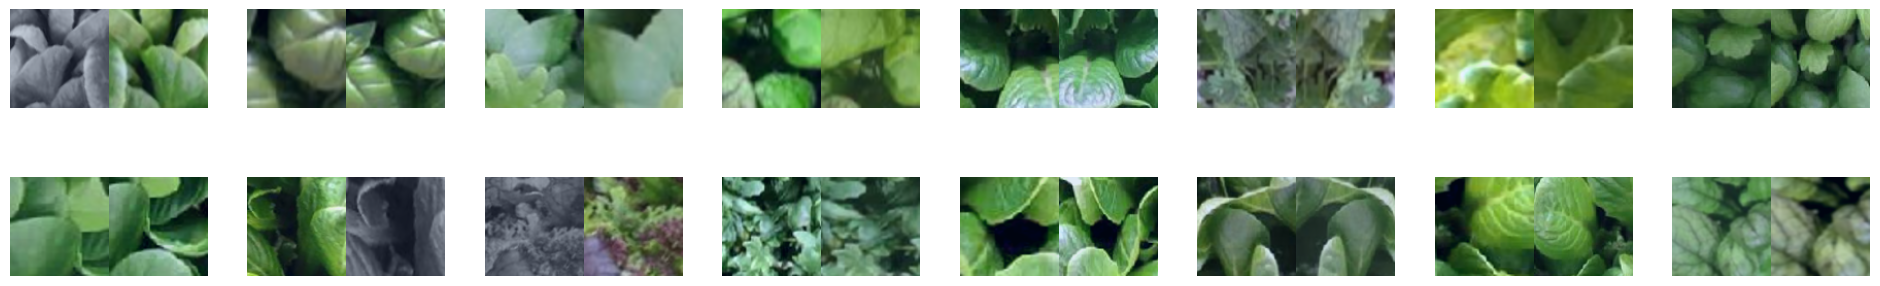

In [ ]:
display_imgs = next(train_ds.as_numpy_iterator())
max_pixel = np.max([display_imgs[0].max(), display_imgs[1].max()])
min_pixel = np.min([display_imgs[0].min(), display_imgs[1].min()])

tfsim_visualization.visualize_views(
    views=display_imgs,
    num_imgs=16,
    views_per_col=8,
    max_pixel_value=max_pixel,
    min_pixel_value=min_pixel,
)

## Contrastive Model Setup

The following section creates the sub-models used by the different algorithms. There are various architectures for building self-supervised models which may include some of the following:
* **Backbone**: This is the base model and is typically an existing architecture like ResNet or EfficientNet.
* **Projector**: This is a small multi-layer Neural Net and provides the embedding features at the end of training.
* **Predictor**: This model is used by BYOL and SimSiam and provides an additional small multi-layer Neural Net.

Additionally, many papers show a single `encoder` block, but this often contains both the `Backbone` and the `Projector` network.

![contrastive_loss_functions.png](https://raw.githubusercontent.com/tensorflow/similarity/master/assets/images/contrastive_loss_functions.png)

The diagram above shows three self-supervised architectures supported by TensorFlow Similarity. They all share a common structure:
* Processing multiple views of the same example.
* Using a backbone model for learning the representation output.
* Using a projector for the embedding output.
* Additionally, note that the loss is symmetric, so we compute it twice during each step. First for view 1 and then a second time for view 2. These two losses are then summed up to compute the final aggregate loss.

Peculiarities of SimSiam algorithms:
* SimSiam only compares the cosine distance between the pairs of augmented views. This means there are no negative examples in the loss, and consequently, the batch size can be much smaller.
* The SimSiam architecture requires an additional Predictor network.
* The SimSiam architecture also uses a stop-gradient to ensure that we only flow the gradient from the target view.


TensorFlow Similarity offers a common set of modules to construct the common parts, and implement the parts which are specific to popular self-supervised algorithms on top of it. Attempting to offer flexibility to add your own algorithm or reuse proven architectures that the results we have reproduced.

### SYNC BATCHNORM UTILITY FUNCTION

In [ ]:
def convert_sync_batchnorm(model: tf.keras.Model) -> tf.keras.Model:
    """Replace BatchNormalization layers to SyncBatchNormalization in place.
    WARNINGS:
    * This function is tested only with efficientnet and resnet
    * The returned model has shared layers with the input one. One of them should be disposed.
    """

    layer2newtensor = {}
    in_ = tf.keras.layers.Input(model.input.shape[1:])
    layer2newtensor[model.input.name] = in_
    for layer in model.layers[1:]:
        assert len(layer.inbound_nodes) == 1
        if isinstance(layer.inbound_nodes[0].inbound_layers, list):  # mutliple inputs
            x = [layer2newtensor[in_l.name] for in_l in layer.inbound_nodes[0].inbound_layers]
        else:
            x = layer2newtensor[layer.inbound_nodes[0].inbound_layers.name]
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer = tf.keras.layers.BatchNormalization(**layer.get_config(), synchronized=True)

        if "truediv" in layer.name:
            # efficeientnet edge case
            # https://github.com/keras-team/keras/blob/v2.9.0/keras/applications/efficientnet.py#L334
            x = layer(x, layer.inbound_nodes[0]._flat_arguments[1])
        else:
            x = layer(x)

        layer2newtensor[layer.name] = x
    out_ = layer2newtensor[model.layers[-1].name]
    new_model = tf.keras.Model(inputs=in_, outputs=out_, name=model.name)
    new_model.set_weights(model.get_weights())
    return new_model

## BACKBONE MODEL
different models can be used as a backbone for SimSiam architecture. Tensorflow Similarity module implements ResNet18/50 and EfficientNet. We also implemented ConvNeXt and MobileNet, wrapping these models into the SimilarityModel class of Tensorflow Similarity. In order to correctly implement it as the backbone.

### CUSTOM COVNEXT SIMILARITY LEARNING (BACKBONE)
We tried to use the ConvNeXt based model we trained (.86 in CodaLab Test) and use it as a backbone, to see if training it in this way would have improved its performance.

In [ ]:
from tensorflow_similarity.models import SimilarityModel

def get_convnext():
  convnext_full = tf.keras.models.load_model('convnext')
  return convnext_full

def get_convnext_backbone(with_input = False):
  convnext_full = get_convnext()
  # Split the model into two parts
  inputs = tf.keras.layers.Input(shape=(96,96,3), name = 'input_1')
  conv_base_output = convnext_full.get_layer('convnext_base')(input)

  if with_input:
    return tf.keras.Model(inputs=inputs, outputs=conv_base_output)
  else:
    return conv_base_output

def get_convnext_classifier():
  convnext_full = get_convnext()
  # Create a new model for the last layers
  last_layers_output = convnext_full.get_layer('drop0').output
  last_layers_output = convnext_full.get_layer('c_dense0')(last_layers_output)
  last_layers_output = convnext_full.get_layer('c_output')(last_layers_output)

  #last_layers_model = Model(inputs=input_layer.input, outputs=last_layers_output)
  return last_layers_output

def get_convnext_similarity_backbone() -> SimilarityModel:
  convnext_full = get_convnext()
  #input_layer = convnext_full.get_layer('input_2')
  inputs = tf.keras.layers.Input(shape=(96,96,3), name = 'input_1')
  conv_base_output = convnext_full.get_layer('convnext_base')
  conv_base_output.trainable = True
  conv_base_output = convert_sync_batchnorm(conv_base_output)
  num_unfreeze_layers = 10  # You can adjust this number based on the actual architecture
  for layer in conv_base_output.layers[:-num_unfreeze_layers]:
      print(layer)
      layer.trainable = False
  conv_base_output = conv_base_output(inputs)
  model = SimilarityModel(inputs=inputs, outputs=conv_base_output)
  #model.trainable = True
  #convnext_full.get_layer('convnext_base').summary()
  return model

### CUSTOM MOBILENET FOR SIMILARITY LEARNING (BACKBONE)

In [ ]:
"MobileNet backbone for similarity learning"
from __future__ import annotations

import re

from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

from tensorflow_similarity.models import SimilarityModel

def MobileNetV2Sim(
    input_shape: tuple[int, int, int],
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    pooling='avg',
    trainable: str = "full"
) -> SimilarityModel:

    # input
    inputs = layers.Input(shape=input_shape)
    x = inputs

    x = build_mbv2net(weights, trainable, alpha, pooling)(x)

    if include_top and pooling is not None:
        outputs = layers.Dense(128)(x)
    else:
        outputs = x

    return SimilarityModel(inputs, outputs)


def build_mbv2net(weights: str | None = "imagenet", trainable: str = "full", alpha: float = 1.0, pooling: str | None = 'avg') -> tf.keras.Model:
    """Build the requested mobilenet.

    Args:
        weights: Use pre-trained weights - the only available currently being
        imagenet.

        trainable: Make the mobilenet backbone fully trainable or partially
        trainable.
        - "full" to make the entire backbone trainable
        - "frozen" to make it not trainable.

    Returns:
        The output layer of the mobilenet model
    """

    mbnet = MobileNetV2(weights=weights, include_top=False, alpha=alpha, pooling=pooling)
    mbnet = convert_sync_batchnorm(mbnet)

    if trainable == "full":
        mbnet.trainable = True
    elif trainable == "frozen":
        mbnet.trainable = False
    else:
        raise ValueError(f"{trainable} is not a supported option for 'trainable'.")

    # Don't train the BN layers if we are loading pre-trained weights.
    #if weights:
    for layer in mbnet.layers:
        if isinstance(layer, layers.experimental.SyncBatchNormalization) or isinstance(
            layer, layers.BatchNormalization
        ):
            layer = tf.keras.layers.BatchNormalization(**layer.get_config(), synchronized=True)

    return mbnet

### Backbone Model

This function returns the selected backbone

In [ ]:
def get_backbone(img_size, activation="relu", preproc_mode="torch"):
    input_shape = (img_size, img_size, 3)
    backbone = get_convnext_similarity_backbone()
    return backbone

#with strategy.scope():
backbone = get_backbone(IMG_SIZE)
backbone.summary()

### Projector and Predictor Model
We kept the default Projector and Predictor networks implemented in Tensorflow Similarity. For SimSiam. they consist in 2 FC layers each.


In [ ]:
projector = None  # Passing None will automatically build the default projector.
predictor = None  # Passing None will automatically build the default predictor.

## Self-Supervised Algorithm
The model training is very sensitive to the learning rate decay and weight decay (possible source of representation collapse).

SimSiam requires using SGD with weight decay from TF Addons. Adding weight decay as a kernel_regularizer doesn't seem to be able to reproduce the published results in the paper.

In [ ]:
#with strategy.scope():
contrastive_model = tfsim.models.create_contrastive_model(
    backbone=backbone,
    projector=projector,
    predictor=predictor,
    algorithm=ALGORITHM,
    name=ALGORITHM,
)

# loss for SimSiam algorithm
loss = tfsim_losses.SimSiamLoss(projection_type="cosine_distance", name=ALGORITHM)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
)
wd_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=WEIGHT_DECAY,
    decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
)
optimizer = tfa.optimizers.SGDW(learning_rate=lr_decayed_fn, weight_decay=wd_decayed_fn, momentum=0.9)

### Compile

In [ ]:
#with strategy.scope():
contrastive_model.compile(
    optimizer=optimizer,
    loss=loss,
)

### Callbacks

We track the training using several callbacks.

* **EvalCallback** creates an index at the end of each epoch and provides a proxy for the nearest neighbor matching classification using `binary_accuracy`.
* **EarlyStopping** on the binary accuracy metric to stop the training and avoid overfitting.

In [ ]:
log_dir = "models/logs/" + f"{loss.name}_{time.time()}"
chkpt_dir = "models/checkpoints" + f"{loss.name}"

evb = tfsim_callbacks.EvalCallback(
    img_scaling(tf.cast(x_query, tf.float32)),
    y_query,
    img_scaling(tf.cast(x_index, tf.float32)),
    y_index,
    metrics=["binary_accuracy"],
    k=1
    #tb_logdir=log_dir,
)
mcp = tf.keras.callbacks.ModelCheckpoint(
    filepath=chkpt_dir,
    monitor="binary_accuracy",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
)
es = tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', patience=30, restore_best_weights=True, mode='auto')

## Model Training

The model training provides a number of metrics.
- **loss**: This represents the total loss over the contrastive batch. Separate contrastive and regularization losses will also be shown if there are trainable variables in the model layers.
- **proj_std and pred_std**: These are added as metric logging layers in the model and show the std of the activations of the final layer in the projector or predictor models.
- **binary_accuracy**: This is the nearest neighbor matching classification accuracy. A new index is built at the end of each epoch and the accuracy is computed using the query and index examples.

In [ ]:
gc.collect()
#with strategy.scope():
history = contrastive_model.fit(
    train_ds,
    epochs=PRE_TRAIN_EPOCHS,
    steps_per_epoch=PRE_TRAIN_STEPS_PER_EPOCH,
    callbacks=[evb, es],
    verbose=1,
)

In [ ]:
'''save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
contrastive_model.backbone.save('contrastive_model_backbone', options=save_locally)'''

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history["loss"])
#plt.plot(history.history["val_loss"])
plt.grid()
plt.title(f"{loss.name} - loss")

plt.subplot(1, 3, 2)
plt.plot(history.history["proj_std"], label="proj")
if "pred_std" in history.history:
    plt.plot(history.history["pred_std"], label="pred")
plt.grid()
plt.title(f"{loss.name} - std metrics")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history["binary_accuracy"], label="acc")
plt.grid()
plt.title(f"{loss.name} - match metrics")
plt.legend()

plt.show()

## Save and Reload

The `ContrastiveModel` contains a set of sub-models and custom train and test steps. Consequently, the `ContrastiveModel` implements a custom save function that performs the following:
* Saves each of the sub models, including the predictor if one exists.
* A JSON file containing the serialized Loss, Metrics, and Optimizer.
* The Optimizer weighs as a npy file.

We also provide a custom `load_model()` function that restores the `ContrastiveModel` and supports continued training.

In [ ]:
# saving and reloading the contrastive model gave problems
# we preferred to directly train the full model first and then save it instead
contrastive_model = tf.keras.models.load_model(
    "SSL_trials/mnv2_simsiam_defprojector_defpredictor",
    custom_objects={
        "ContrastiveModel": tfsim.models.ContrastiveModel,
        "ActivationStdLoggingLayer": tfsim.layers.ActivationStdLoggingLayer,
    },
)

## Evaluation

This final section trains two different classifiers.

1. **No Pre-training**: Uses a ResNet18 model and a simple linear layer.

2. **Pre-trained** Uses the frozen pre-trained backbone from the ContrastiveModel and only trains the weights in the linear layer.

The original train data is partitioned into eval_train and eval_val splits and a simplified augmentation is applied to the training data.

The models are then trained for 10 epochs and the classification accuracy is evaluated on the held out test split.

In [ ]:
TEST_EPOCHS = 1000
TEST_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
VAL_STEPS_PER_EPOCH = len(x_test) // BATCH_SIZE

In [ ]:
@tf.function
def eval_augmenter(img):
    # random resize and crop. Increase the size before we crop.
    img = tfsim.augmenters.augmentation_utils.cropping.crop_and_resize(
        img, IMG_SIZE, IMG_SIZE, area_range=(0.2, 1.0)
    )
    # random horizontal flip
    img = tf.image.random_flip_left_right(img)
    img = tf.clip_by_value(img, 0.0, 255.0)

    return img

In [ ]:
eval_train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
eval_train_ds = eval_train_ds.repeat()
eval_train_ds = eval_train_ds.shuffle(1024)
eval_train_ds = eval_train_ds.map(lambda x, y: (eval_augmenter(x), y), tf.data.AUTOTUNE)
eval_train_ds = eval_train_ds.map(lambda x, y: (img_scaling(x), y), tf.data.AUTOTUNE)
eval_train_ds = eval_train_ds.batch(BATCH_SIZE)
eval_train_ds = eval_train_ds.prefetch(tf.data.AUTOTUNE)

eval_val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
eval_val_ds = eval_val_ds.repeat()
eval_val_ds = eval_val_ds.shuffle(1024)
eval_val_ds = eval_val_ds.map(lambda x, y: (img_scaling(tf.cast(x, dtype=tf.float32)), y), tf.data.AUTOTUNE)
eval_val_ds = eval_val_ds.batch(BATCH_SIZE)
eval_val_ds = eval_val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
eval_test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
eval_test_ds = eval_test_ds.map(lambda x, y: (img_scaling(tf.cast(x, dtype=tf.float32)), y), tf.data.AUTOTUNE)
eval_test_ds = eval_test_ds.batch(BATCH_SIZE)
eval_test_ds = eval_test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
gc.collect()

In [ ]:
#takes the backbone and appends the last 1 unit layer
def get_eval_model(img_size, backbone, total_steps, trainable=True, lr=1.8):
    backbone.trainable = trainable
    inputs = tf.keras.layers.Input((img_size, img_size, 3), name="eval_input")
    x = backbone(inputs, training=trainable)
    o = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, o)
    cosine_decayed_lr = tf.keras.experimental.CosineDecay(initial_learning_rate=lr, decay_steps=total_steps)
    opt = tf.keras.optimizers.AdamW()
    #opt = tf.keras.optimizers.SGD(cosine_decayed_lr, momentum=0.9)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    return model

### Pretrained

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='auto')
with strategy.scope():
  pt_eval_model = get_eval_model(
      img_size=IMG_SIZE,
      backbone=contrastive_model.backbone,
      total_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH,
      trainable=False,
      lr=1e-3,
  )
  pt_eval_model.summary()
  pt_history = pt_eval_model.fit(
      eval_train_ds,
      batch_size=BATCH_SIZE,
      epochs=TEST_EPOCHS,
      steps_per_epoch=TEST_STEPS_PER_EPOCH,
      validation_data=eval_val_ds,
      validation_steps=20,
      callbacks = [es]
  )

In [ ]:
# the only model we saved is the one trained using resnet50 as backbone, the "less unsatisfiying" model we managed to train using ssl
# other ones did not even get close to performe as well as the standard supervised training
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
pt_eval_model.save('complete_ssl_resnet50_model', options=save_locally)

In [ ]:
with strategy.scope():
  model = tf.keras.models.load_model('complete_ssl_resnet50_model')

In [ ]:
print("pretrained", model.evaluate(eval_test_ds))

### Standard training

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True, mode='auto')
with strategy.scope():
  no_pt_eval_model = get_eval_model(
      img_size=IMG_SIZE,
      backbone=tf.keras.applications.MobileNetV2( #replace with the corresponding model as the one used for self supervised
          include_top=False,
          weights=None,
          pooling='avg'
      ),
      total_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH,
      trainable=True,
      lr=1e-3,
  )
  no_pt_eval_model.summary()
  no_pt_history = no_pt_eval_model.fit(
      eval_train_ds,
      batch_size=BATCH_SIZE,
      epochs=TEST_EPOCHS,
      steps_per_epoch=TEST_STEPS_PER_EPOCH,
      validation_data=eval_val_ds,
      validation_steps=VAL_STEPS_PER_EPOCH,
      callbacks = [es]
  )

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(no_pt_history.history["loss"])
plt.plot(no_pt_history.history["val_loss"])
plt.grid()
plt.title(f"loss")

plt.subplot(1, 2, 2)
plt.plot(no_pt_history.history["accuracy"])
plt.plot(no_pt_history.history["val_accuracy"])
plt.grid()
plt.title(f"accuracy")
plt.legend()

plt.show()

In [ ]:
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
no_pt_eval_model.save('complete_std_mobilenetv2_model', options=save_locally)

In [ ]:
with strategy.scope():
  model = tf.keras.models.load_model('complete_std_resnet50_model')

In [ ]:
print("no pretrain", model.evaluate(eval_test_ds))